# Projet 3i026 

## Intro

#### importation des bibliothèques 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl 

# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')

# Importation de la librairie iads
import iads as iads

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut
import math


## Chargement des données et indexation

**Mise en Forme des Données**


In [2]:
# Chargement des données MovieLens
fname_links ="data/ml-20m/links.csv"
links = pd.read_csv(fname_links, encoding='utf8')

fname ="data/ml-20m/movies.csv"
movies = pd.read_csv(fname, encoding='utf8')

fname ="data/ml-20m/tags.csv"
tags = pd.read_csv(fname, encoding='utf8')

fname ="data/ml-20m/genome-tags.csv"
num_tags = pd.read_csv(fname, encoding='utf8')

fname ="data/ml-20m/ratings.csv"
ratings = pd.read_csv(fname, encoding='utf8')

In [3]:
# Chargement des données complémentaires : Data sets
fname = "data/act_v2.pkl"
acteurs = pkl.load(open(fname, "rb"))

fname = "data/crew_v2.pkl"
equipe= pkl.load(open(fname, "rb"))

fname = "data/film_v2.pkl"
films= pkl.load(open(fname, "rb"))


#### Indexation des données :

***1-Les acteurs :***

In [4]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], len(actors))
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']
            


Actors: une liste dde listes des acteurs dans un film :
[{'name': 'Christian Ulmen', 'id': 675, 'gender': 0, 'cast_id': 6, 'credit_id': '52fe49cfc3a368484e140fed', 'character': 'Jonas', 'order': 0, 'profile_path': '/8kVG8RGO47mSRZ1ut0rxzbmFkKo.jpg'}]

In [5]:
films[0]

{'adult': False,
 'backdrop_path': '/dji4Fm0gCDVb9DQQMRvAI8YNnTz.jpg',
 'genre_ids': [16, 35, 10751],
 'id': 862,
 'original_language': 'en',
 'original_title': 'Toy Story',
 'overview': "Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
 'popularity': 22.773,
 'poster_path': '/rhIRbceoE9lR4veEXuwCC2wARtG.jpg',
 'release_date': '1995-10-30',
 'title': 'Toy Story',
 'video': False,
 'vote_average': 7.9,
 'vote_count': 9550}

***2- Les films***

Indexer les films :

In [6]:
films_index = dict() # title->val
films_inv_index = dict() #val->title
for f in films:
    # affecte une valeur à une clé si la clé n'est pas utilisée
    res =films_index.setdefault(f['title'], len(films_index))
    if res == len(films_index)-1:
        films_inv_index[len(films_index)-1] = f['title']  


 Récupération des listes de catégories et acteurs d'un film :' 

In [7]:
film_actors= dict()#pour chaque indice de film (dans films) la liste des acteurs
actors_film= dict()

for i in range (len(films)) :
    l=[]
    f=films[i]
    indice=films_index[f['title']]
    for a in acteurs[i]:
        if(not(a['name'] in actors_film.keys())):
            actors_film[a['name']]=[]
        actors_film[a['name']].append(indice)    
        l.append(actors[a['name']])
    film_actors[indice]=l  #pour chaque indice de film on recupére ses acteurs

***3- Catégories :***

3-1 Elimination des films : 

In [8]:
movies_reduit=[]
i=0
for t in movies.itertuples() :
    d=t._asdict()
    m=d.get('title')
    s=(m.split('('))[0].strip("\"").strip()
    if s in films_index.keys():
        movies_reduit.append(t)
    i+=1
    

data=(pd.DataFrame(movies_reduit)).drop(columns="Index")
movies_reduit=data

In [9]:
print(movies_reduit.head(5))

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Indexation des movies_reduit avec comme cle l'indice de films 

In [10]:
moviesReduit_index = dict() # title->val
moviesReduit_inv_index = dict() #val->title,id dans la table movies
moviesReduit_correspendance=dict() #id dans la table movies->id dans la table films, titre 
for f in movies_reduit.itertuples():
    # affecte une valeur à une clé si la clé n'est pas utilisée
    
    d=f._asdict()
    m=d.get('title')
    title=(m.split('('))[0].strip("\"").strip()
    indice= films_index[title] #recupere l'indice dans films
    moviesReduit_index[title]= indice 
    moviesReduit_inv_index[indice]= [title,d.get('movieId')]
    moviesReduit_correspendance[d.get('movieId')]=[indice ,title]

In [11]:
cpt=0
for i in films_index.values():
    for a in acteurs[i]:
        if(a['name']== "Tom Hanks"):
            cpt+=1
            break
print("nombre de films de Tom Hanks :",cpt)


nombre de films de Tom Hanks : 57


-Indexation des categories

In [12]:
categorie_index={}
categorie_inv_index={}
for i in range(len(movies_reduit)):
    cat_name=(movies_reduit['genres'][i]).split('|')
    for name in  cat_name:
        res =categorie_index.setdefault(name, len(categorie_index))
        if res == len(categorie_index)-1:
            categorie_inv_index[len(categorie_index)-1] = name 

In [13]:
print(categorie_index)
print(categorie_inv_index)
print(len(categorie_index))

{'Adventure': 0, 'Animation': 1, 'Children': 2, 'Comedy': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Mystery': 11, 'Sci-Fi': 12, 'IMAX': 13, 'Documentary': 14, 'War': 15, 'Musical': 16, 'Western': 17, 'Film-Noir': 18, '(no genres listed)': 19}
{0: 'Adventure', 1: 'Animation', 2: 'Children', 3: 'Comedy', 4: 'Fantasy', 5: 'Romance', 6: 'Drama', 7: 'Action', 8: 'Crime', 9: 'Thriller', 10: 'Horror', 11: 'Mystery', 12: 'Sci-Fi', 13: 'IMAX', 14: 'Documentary', 15: 'War', 16: 'Musical', 17: 'Western', 18: 'Film-Noir', 19: '(no genres listed)'}
20


Recuperer les catégories (leurs indexs) des films

In [14]:
film_categories= dict()#pour chaque indice de film (dans index) on a les id des catégories

for t in movies_reduit.itertuples() :
    cat_id=[]
    d=t._asdict()
    m=d.get('title')
    title=(m.split('('))[0].strip("\"").strip()
    indice=films_index[title]
    cat=d.get('genres').split('|')
    for c in cat :
        cat_id.append(categorie_index[c])
    film_categories[indice]=cat_id

Preparation d'un LabelSeet pour le premier apprentissage 

In [15]:
dim = len(categorie_index) 
ratingPredic_base = ls.LabeledSet(dim + 2) 

for i in moviesReduit_inv_index.keys() :
    cat =[]
    m=films[i]
    X=[]
    if('vote_count' in m.keys()) :
        X.append(m['vote_count'])
    else:
        X.append(0)
    if('popularity' in m.keys()):
        X.append(m['popularity'])
    else:
        X.append(0)
    cat=film_categories[i]
    for j in range(dim) :
        if(j in cat):
            X.append(1)
        else:
            X.append(0)
    ratingPredic_base.addExample(X,m['vote_average'])

    

In [16]:
def affiche_base(LS):
    """ LabeledSet
        affiche le contenu de LS
    """
    for i in range(0,LS.size()):
        print("Exemple "+str(i))
        print("\tdescription : ",LS.getX(i))
        print("\tlabel : ",LS.getY(i))
    return



## Fonctions auxiliares : 

In [17]:
def split(pourcentage,data_set): #pourcentage de train
    taille=int(pourcentage*data_set.size()/100)
    train_set=ls.LabeledSet(data_set.input_dimension)
    test_set=ls.LabeledSet(data_set.input_dimension)
    for i in range(taille):
        train_set.addExample(data_set.getX(i),data_set.getY(i))
    for i in range(taille,data_set.size()):
        test_set.addExample(data_set.getX(i),data_set.getY(i))
    return train_set,test_set

In [18]:
import statistics as stat
def normalisation(lset):
    for i in range(lset.getInputDimension()):
        colonne=lset.x[:,i]
        moy=stat.mean(list(train_set.x[:,1]))
        lset.x[:,i]-moy
    return lset

## Regression supervisée : 

####  I. Prediction du vote_average d'un film à partir de vote_count, popularity et les catégories:

In [19]:
train_set,test_set=split(50,ratingPredic_base)

In [20]:
class ClassifierKNN(cl.Classifier):
    def __init__(self, input_dimension,k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension=input_dimension
        self.k=k  
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        list_distance=[]
        for i in range(self.reference.size()):
            point=self.reference.getX(i)
            d=0
            for j in range(self.input_dimension):
                d+=(point[j]-x[j])**2
            list_distance.append(d)
        list_distance=np.argsort(list_distance)
        list_distance=list_distance[0:self.k]
        som=0
        for i in list_distance:
            som+=self.reference.getY(i)
        return som/self.k

    def train(self, labeledSet):
        self.reference=labeledSet
    def accuracy(self, dataset,e):
        acc=0
        for i in range (dataset.size()):
            if (abs(dataset.getY(i)-self.predict(dataset.getX(i))))<e:
                acc+=1;
        moy=acc/dataset.size()
        return(moy)
def test_accuracy(k,train_set,test_set,e):
    l=[]
    for j in range(1,k+1):
        knn = ClassifierKNN(train_set.input_dimension,j)
        knn.train(train_set)
        l.append(knn.accuracy(test_set,e))
    return l
def test_accuracy_e(k,train_set,test_set,e):
    l=[]
    for j in e:
        knn = ClassifierKNN(train_set.input_dimension,k)
        knn.train(train_set)
        l.append(knn.accuracy(test_set,j))
    return l
def test_accuracy_tailletrain(k,ratingPredic_baseNormalise,e):
    l=[]
    x=[]
    for j in range(10,60,10):
        x.append(j)
        train_set,test_set=split(j,ratingPredic_base)
        t,test_set=(99,ratingPredic_base)
        knn = ClassifierKNN(train_set.input_dimension,k)
        knn.train(train_set)
        l.append(knn.accuracy(test_set,e))
    return l

In [21]:
knn = ClassifierKNN(ratingPredic_base.getInputDimension(),11)
knn.train(train_set)

##### a. Prédiction de vote_average:

In [22]:
f=ratingPredic_base.getX(17000)
y=ratingPredic_base.getY(17000)
print("ID film : 17000 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(17500)
y=ratingPredic_base.getY(17500)
print("ID film : 17500 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(7500)
y=ratingPredic_base.getY(7500)
print("ID film : 7500 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(862)
y=ratingPredic_base.getY(862)
print("ID film : 862 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(17)
y=ratingPredic_base.getY(17)
print("ID film : 17 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(175)
y=ratingPredic_base.getY(175)
print("ID film : 175 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(75)
y=ratingPredic_base.getY(75)
print("ID film : 75 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_base.getX(86)
y=ratingPredic_base.getY(86)
print("ID film : 86 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)

ID film : 17000 Prediction du vote_average :  [6.36363636]  Vraie valeur du vote_average : [6.4]
ID film : 17500 Prediction du vote_average :  [5.88181818]  Vraie valeur du vote_average : [7.8]
ID film : 7500 Prediction du vote_average :  [6.5]  Vraie valeur du vote_average : [7.8]
ID film : 862 Prediction du vote_average :  [7.03636364]  Vraie valeur du vote_average : [7.4]
ID film : 17 Prediction du vote_average :  [6.74545455]  Vraie valeur du vote_average : [6.2]
ID film : 175 Prediction du vote_average :  [6.55454545]  Vraie valeur du vote_average : [7.4]
ID film : 75 Prediction du vote_average :  [6.21818182]  Vraie valeur du vote_average : [6.1]
ID film : 86 Prediction du vote_average :  [6.]  Vraie valeur du vote_average : [5.6]


In [23]:
train_set_forAccuracy,test_set_forAccuracy=split(99,ratingPredic_base)#En raison du temps de calcul de l'accuracy 
print("Acuracy pour le KNN :",knn.accuracy(test_set_forAccuracy,0.5)) #on réduit la table de test mais en gardant la meme
                                                                      #table de train

Acuracy pour le KNN : 0.3333333333333333


##### b. Variation de l'accuracy en fonction de k :

In [24]:
l=test_accuracy(10,train_set,test_set_forAccuracy,0.5)
plt.title("Variation de l'accuracy en fonction de k")
plt.xlabel('Variation de k')
plt.ylabel('Accuracy')
plt.plot(l)
plt.show()

KeyboardInterrupt: 

##### c. Variation de l'accuracy en fonction de epsilon:

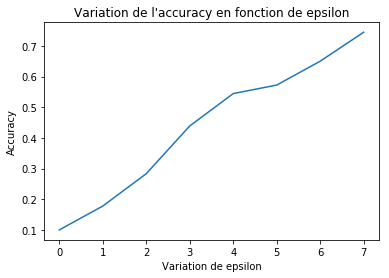

In [69]:
l=test_accuracy_e(10,train_set,test_set_forAccuracy,[0.1,0.2,0.4,0.7,0.9,1,1.2,1.5])
plt.title("Variation de l'accuracy en fonction de epsilon")
plt.xlabel('Variation de epsilon')
plt.ylabel('Accuracy')
plt.plot([0.1,0.2,0.4,0.7,0.9,1,1.2,1.5],l)

plt.show()

##### d. Prédiction de vote_average aprés normalisation :

In [72]:
ratingPredic_baseNormalise= normalisation(ratingPredic_base)
train_setNormalise,test_setNormalise=split(50,ratingPredic_baseNormalise)

In [73]:
knn.train(train_setNormalise)

f=ratingPredic_baseNormalise.getX(17000)
y=ratingPredic_baseNormalise.getY(17000)
print("ID film : 17000 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(17500)
y=ratingPredic_baseNormalise.getY(17500)
print("ID film : 17500 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(7500)
y=ratingPredic_baseNormalise.getY(7500)
print("ID film : 7500 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(862)
y=ratingPredic_baseNormalise.getY(862)
print("ID film : 862 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(17)
y=ratingPredic_baseNormalise.getY(17)
print("ID film : 17 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(175)
y=ratingPredic_baseNormalise.getY(175)
print("ID film : 175 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(75)
y=ratingPredic_baseNormalise.getY(75)
print("ID film : 75 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)
f=ratingPredic_baseNormalise.getX(86)
y=ratingPredic_baseNormalise.getY(86)
print("ID film : 86 Prediction du vote_average : ",knn.predict(f)," Vraie valeur du vote_average :",y)

ID film : 17000 Prediction du vote_average :  [ 6.36363636]  Vraie valeur du vote_average : [ 6.4]
ID film : 17500 Prediction du vote_average :  [ 5.88181818]  Vraie valeur du vote_average : [ 7.8]
ID film : 7500 Prediction du vote_average :  [ 6.5]  Vraie valeur du vote_average : [ 7.8]
ID film : 862 Prediction du vote_average :  [ 7.03636364]  Vraie valeur du vote_average : [ 7.4]
ID film : 17 Prediction du vote_average :  [ 6.74545455]  Vraie valeur du vote_average : [ 6.2]
ID film : 175 Prediction du vote_average :  [ 6.55454545]  Vraie valeur du vote_average : [ 7.4]
ID film : 75 Prediction du vote_average :  [ 6.21818182]  Vraie valeur du vote_average : [ 6.1]
ID film : 86 Prediction du vote_average :  [ 6.]  Vraie valeur du vote_average : [ 5.6]


##### e. Variation de l'accuracy en fonction du pourcentage taille du train :

In [75]:
l,x=test_accuracy_tailletrain(10,ratingPredic_baseNormalise,0.5)
plt.title("Variation de l'accuracy en fonction du pourcentage taille du train")
plt.xlabel('Variation du pourcentage')
plt.ylabel('Accuracy')
plt.plot(x,l)
plt.show()

KeyboardInterrupt: 

## Classification supervisée

### Classification des catégorie :

##### a. Construction des tables train et test :

In [26]:
class ClassifierKNN_unique(cl.Classifier):
    def __init__(self, input_dimension):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension=input_dimension
        self.k=1 
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        list_distance=[]
        for i in range(self.reference.size()):
            point=self.reference.getX(i)
            d=0
            for j in range(self.input_dimension):
                d+=(point[j]-x[j])**2
            list_distance.append(d)
        list_distance=np.argsort(list_distance)
        voisin=list_distance[0]
        return self.reference.getY(voisin)

    def train(self, labeledSet):
        self.reference=labeledSet

In [27]:
taille=int(60*len(moviesReduit_index)/100)
train_id=list(moviesReduit_index.values())[0:taille]
test_id=list(moviesReduit_index.values())[taille:len(moviesReduit_index.values())]
print(len(train_id),len(test_id))


10764 7176


In [28]:
from itertools import zip_longest
actors_categorie={}#pour chaque acteur on compte le nombre de films qu'il a dans chaque catégorie 
for i in actors_film.keys():# i est le nom de l'acteur
    lesCategorie=[0]*len(categorie_index)
    lesFilms=actors_film[i]# liste des films de l'acteur i
    for f in lesFilms:
        if(f in train_id):
            if(f in film_categories.keys()):
                cat_film=film_categories[f]
                for j in cat_film:
                    lesCategorie[j]+=1
        actors_categorie[i]=lesCategorie

#Pour chaque film on somme actors_categorie des ses acteurs
film_sum_categorie={}
for f in film_actors.keys():# f est l'indice du film
    if(f in train_id):#jjjjjjj
        c=[0]*20
        lesActeurs=film_actors[f]
        for a in lesActeurs:
            r=[]
            for val in zip_longest(c, actors_categorie[actors_inv[a]], fillvalue = '0'):
                r.append(sum(val))
            c=r
        film_sum_categorie[f]=c


In [29]:
dim = len(categorie_index) 
catPredict_base = ls.LabeledSet(dim) 
for i in film_sum_categorie.keys():
    catPredict_base.addExample(film_sum_categorie[i],film_categories[i][0])
    

    

In [30]:
def getSum_acteur_categorie(act):# pour generer le X du film a prédir 
    #pour chaque acteur on compte le nombre de films qu'il a dans chaque catégorie 
    lesCategorie=[0]*len(categorie_index)
    for a in act:# a est le nom de l'acteur
        i=actors_inv[a]
        lesFilms=actors_film[i]# liste des films de l'acteur i
        for f in lesFilms:
            if(f in train_id):
                if(f in film_categories.keys()):
                    cat_film=film_categories[f]
                    for j in cat_film:
                        lesCategorie[j]+=1
    return lesCategorie

In [31]:
knn_unique = ClassifierKNN_unique(20)
knn_unique.train(catPredict_base)

In [32]:
dim = len(categorie_index) 
test_set_cat=ls.LabeledSet(dim) 
for i in test_id:
    act=film_actors[i]
    test_set_cat.addExample(getSum_acteur_categorie(act),film_categories[i][0])


In [33]:
X=getSum_acteur_categorie(film_actors[17000])
c=knn_unique.predict(X)[0]
print("le nom du film est ",films_inv_index[17000],", sa catégorie prédite est ",c,categorie_inv_index[c]," ses vraies catégories ",film_categories[17000])

X=getSum_acteur_categorie(film_actors[16005])
c=knn_unique.predict(X)[0]
print("le nom du film est ",films_inv_index[16005],", sa catégorie prédite est ",c,categorie_inv_index[c]," ses vraies catégories ",film_categories[16005])

X=getSum_acteur_categorie(film_actors[17007])
c=knn_unique.predict(X)[0]
print("le nom du film est ",films_inv_index[17007],", sa catégorie prédite est ",c,categorie_inv_index[c]," ses vraies catégories ",film_categories[17007])

X=getSum_acteur_categorie(film_actors[15500])
c=knn_unique.predict(X)[0]
print("le nom du film est ",films_inv_index[15500],", sa catégorie prédite est ",c,categorie_inv_index[c]," ses vraies catégories ",film_categories[15500])

le nom du film est  50/50 , sa catégorie prédite est  6 Drama  ses vraies catégories  [3, 6]
le nom du film est  Happythankyoumoreplease , sa catégorie prédite est  3 Comedy  ses vraies catégories  [3, 6]
le nom du film est  Generation P , sa catégorie prédite est  7 Action  ses vraies catégories  [3, 6, 12]
le nom du film est  Not Forgotten , sa catégorie prédite est  9 Thriller  ses vraies catégories  [9]


In [52]:
#print("Acuracy pour le KNN :",knn_unique.accuracy(test_set_cat))

### Classification des films pour un utilisateur (recommendé ou pas )

#### 1. construction du labeledSet

In [88]:
import random
def get_user_movies(id):#on recupere les films q'un user a vu
    films=[]
    rat=[]
    for i in range(len(ratings)):
        if(id==ratings['userId'][i]):
            films.append(ratings['movieId'][i])
            rat.append(ratings['rating'][i])
        if(id<ratings['userId'][i]):
            return films,rat
    return films,rat


In [83]:
#construction du labeledSet user_ratingPredic_base 
user_films,user_ratings=get_user_movies(1)
dim = len(categorie_index) 
user_ratingPredic_base = ls.LabeledSet(dim + 3) 

for i in range(len(user_ratings)):
    cat =[]
    if(user_films[i] in moviesReduit_correspendance.keys()):#si le film appartient a la table movies_reduit
        info=moviesReduit_correspendance[user_films[i]]
        indice=info[0]#indice dans la table films
        titre=info[1]#titre du film
        m=films[indice]#ligne du film dans la table films 
        X=[]
        if('vote_count' in m.keys()):
            X.append(m['vote_count'])
        else:
            X.append(0)
        if('popularity' in m.keys()):
            X.append(m['popularity'])
        else:
            X.append(0)
        if('vote_average' in m.keys()):
            X.append(m['vote_average'])
        else:
            X.append(0)
            
        cat=film_categories[indice]
        for j in range(dim) :
            if(j in cat):
                X.append(1)
            else:
                X.append(0)
        if(user_ratings[i]>=4): # le film a une note supérieur à 4/5
            user_ratingPredic_base.addExample(X,1)
        else:
            user_ratingPredic_base.addExample(X,-1)

In [84]:
train_set_user,test_set_user=split(70,user_ratingPredic_base)

#### 2. classifieur KNN

In [209]:
class ClassifierKNN2(cl.Classifier):
    def __init__(self, input_dimension,k):
        """ Constructeur de Classifier
            Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
            Hypothèse : input_dimension > 0
        """
        self.input_dimension=input_dimension
        self.k=k  
        
    def predict(self, x):
        """ rend la prediction sur x (-1 ou +1)
        """
        list_distance=[]
        for i in range(self.reference.size()):
            point=self.reference.getX(i)
            d=0
            for j in range(self.input_dimension):
                d+=(point[j]-x[j])**2
            list_distance.append(d)
        list_distance=np.argsort(list_distance)
        list_distance=list_distance[0:self.k]
        som=0
        for i in list_distance:
            som+=self.reference.getY(i)
        if(som/self.k>=0):
            return 1
        else:
            return -1

    def train(self, labeledSet):
        self.reference=labeledSet 
    def accuracy(self, dataset):
        acc=0
        for i in range (dataset.size()):
            if (dataset.getY(i)*self.predict(dataset.getX(i))>=0):
                acc+=1;
        moy=acc/dataset.size()
        return(moy)
knn_user = ClassifierKNN2(train_set_user.input_dimension,3)
knn_user.train(train_set_user)

    

(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

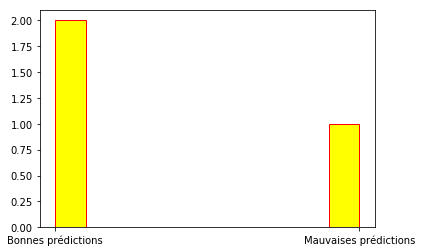

In [220]:
for i in range(test_set_user.size()-1):
    just=1
    faux=1
    if(knn_user.predict(test_set_user.getX(i))==test_set_user.getY(i)[0]):
        just+=1
    else:
        faux+=1
data=["Bonnes prédictions"]*int(just)+["Mauvaises prédictions"]*int(faux)
plt.hist(data, range = (0, 1), color = 'yellow',
            edgecolor = 'red')

#### Accuracy :

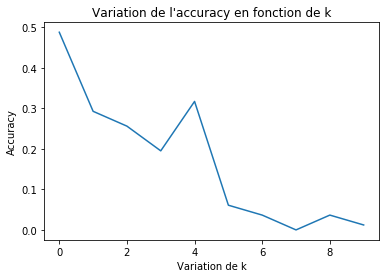

In [205]:
e=0.5
l=test_accuracy(10,train_set_user,test_set_user,e)
plt.title("Variation de l'accuracy en fonction de k")
plt.xlabel('Variation de k')
plt.ylabel('Accuracy')
plt.plot(l)
plt.show()

#### 3. classifieur Perceptron

In [122]:
class ClassifierPerceptron(cl.Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.input_dimension=input_dimension
        self.w=np.zeros(input_dimension)
        self.learning_rate = learning_rate

    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        z = np.dot(x, self.w)
        if(z>=0):
            return 1
        else:
            return -1
    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        indice=np.arange(labeledSet.size())
        random.shuffle(indice)
        accuracies=[]
        loss=0
        for i in indice :
            x=labeledSet.getX(i)
            y=labeledSet.getY(i)
            f=np.dot(x,self.w)
            if(f*y <= 0):
                amelior= x*(y*self.learning_rate)
                self.w=self.w+amelior
                accuracies.append(self.accuracy(labeledSet))
            loss+=(y-f)**2
        return accuracies,loss
    def getW(self):
        return self.w
    def accuracy(self, dataset):
        acc=0
        for i in range (dataset.size()):
            if (dataset.getY(i)*self.predict(dataset.getX(i))>=0):
                acc+=1;
        moy=acc/dataset.size()
        return(moy)
def test_accuracy_learningrate(train_set,test_set):
    x=[]
    l=[]
    k=20
    for j in range(1,k+1):
        x.append(j/k)
        perceptron = ClassifierPerceptron(train_set.input_dimension,j/k)
        perceptron.train(train_set)
        l.append(perceptron.accuracy(test_set))
    return l,x

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

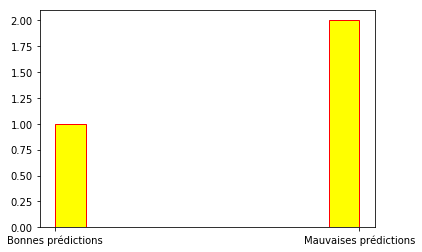

In [223]:
for i in range(test_set_user.size()-1):
    just=1
    faux=1
    if(perceptron.predict(test_set_user.getX(i))==test_set_user.getY(i)[0]):
        just+=1
    else:
        faux+=1
data=["Bonnes prédictions"]*int(just)+["Mauvaises prédictions"]*int(faux)
plt.hist(data, range = (0, 1), color = 'yellow',
            edgecolor = 'red')

#### Accuracy en fonction du learning rate:

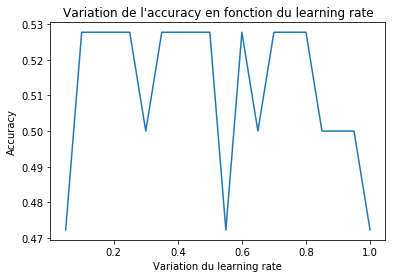

In [97]:
l,x=test_accuracy_learningrate(train_set_user,test_set_user)
plt.title("Variation de l'accuracy en fonction du learning rate")
plt.xlabel('Variation du learning rate')
plt.ylabel('Accuracy')
plt.plot(x,l)
plt.show()

##### Variation du vecteur W :

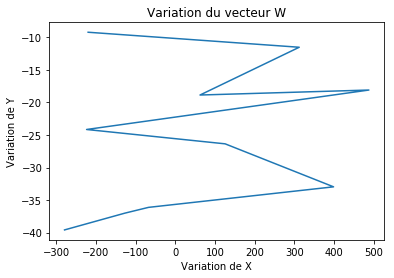

In [90]:
N=10
e=0.06
les_wX=[]
les_wY=[]
perceptron = ClassifierPerceptron(train_set_user.input_dimension,e)

for i in range(N):
    perceptron.train(train_set_user)
    les_wX.append(perceptron.getW()[0])
    les_wY.append(perceptron.getW()[1])
plt.title("Variation du vecteur W")
plt.xlabel('Variation de X')
plt.ylabel('Variation de Y')
plt.plot(les_wX,les_wY)
plt.show()

Le premier graphe représente les valeurs de W qui change aléatoirement selon les indices choisi (on rajoute à w des valeurs parfois positives et parfois négatives)
Par rapport à l'accuracy : elle ne baisse pas. En fait, elle augmente car on apprend donc elle s'améliore, mais ça ne l'empeche pas de diminuer pour des valeurs des pivots de w qui malclasse les anciénnes valeurs    

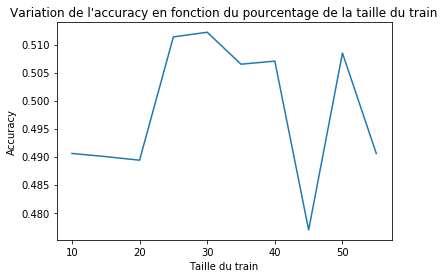

In [110]:
accu=[]
x=[]
perceptron = ClassifierPerceptron(train_set_user.input_dimension,0.06)
for i in range(10,60,5):
    x.append(i)
    train_set_user,test_set_user=split(i,user_ratingPredic_base)
    perceptron.train(train_set_user)
    accu.append(perceptron.accuracy(test_set_user))
plt.title("Variation de l'accuracy en fonction du pourcentage de la taille du train")
plt.xlabel('Taille du train')
plt.ylabel('Accuracy')
plt.plot(x,accu)
plt.show()

L'accuraccy varie entre 0.48 et 0.51 elle est donc moyenne 

In [227]:
train_set_user,test_set_user=split(70,user_ratingPredic_base)
perceptron = ClassifierPerceptron(train_set_user.input_dimension,0.06)
accuracies,loss=perceptron.train(train_set_user)


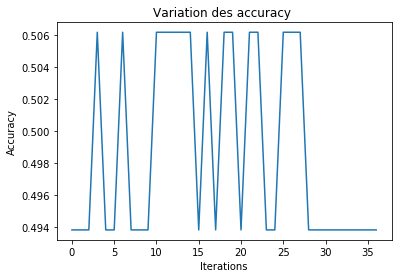

In [228]:
plt.title("Variation des accuracy ")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.plot(accuracies)
plt.show()

##### Loss :

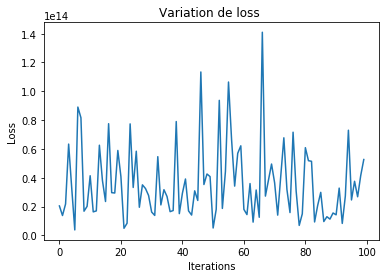

In [146]:
accu=[]
perceptron = ClassifierPerceptron(train_set_user.input_dimension,0.06)
train_set_user,test_set_user=split(70,user_ratingPredic_base)
for i in range(100):
    
    a,l=perceptron.train(train_set_user)
    accu.append(l)
plt.title("Variation de loss du Perceptron ")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(accu)
plt.show()

#### 4. classifieur Perceptron GradientBatch :

In [192]:
class ClassifierGradientBatch(cl.Classifier):
    """ Perceptron de Rosenblatt
    """
    def __init__(self,input_dimension,learning_rate):
        """ Argument:
                - intput_dimension (int) : dimension d'entrée des exemples
                - learning_rate :
            Hypothèse : input_dimension > 0
        """
        self.input_dimension=input_dimension
        self.w=np.zeros(input_dimension)
        self.learning_rate = learning_rate

    def predict(self,x):
        """ rend la prediction sur x (-1 ou +1)
        """
        z = np.dot(x, self.w)
        if(z>=0):
            return 1
        else:
            return -1
    
    
    def train(self,labeledSet):
        """ Permet d'entrainer le modele sur l'ensemble donné
        """
        indice=np.arange(labeledSet.size())
        random.shuffle(indice)
        gradient=0
        loss=0
        for i in indice :
            x=labeledSet.getX(i)
            y=labeledSet.getY(i)
            f=np.dot(self.w,x)
            gradient+=(y-f)*x  
           
            loss+=(y-f)**2
        
        self.w=self.w+self.learning_rate*gradient
        return loss
    def getW(self):
        return self.w

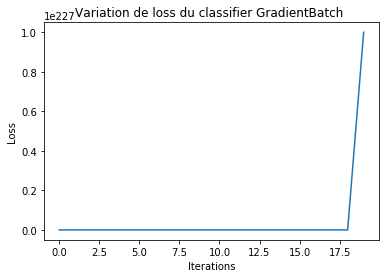

In [195]:
N=20
e=0.06
train_set_user,test_set_user=split(30,user_ratingPredic_base)
GB = ClassifierGradientBatch(train_set_user.input_dimension,e/40)
l=[]
for i in range(N):
    loss=GB.train(user_ratingPredic_base)
    l.append(loss)

plt.title("Variation de loss du classifier GradientBatch ")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(l)
plt.show()

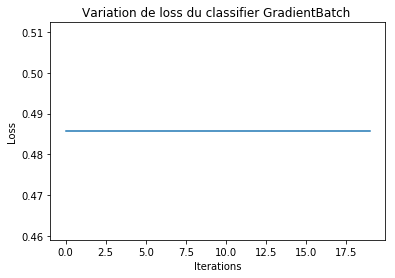

In [196]:
N=20
e=0.06
train_set_user,test_set_user=split(30,user_ratingPredic_base)
GB = ClassifierGradientBatch(train_set_user.input_dimension,e/40)
l=[]
for i in range(N):
    l.append(GB.accuracy(train_set_user))

plt.title("Variation de loss du classifier GradientBatch ")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(l)
plt.show()

**OBSERVATION** On constate que l'accuracy des deux algorithmes de Perceptron est moyenne en general comparé à celle du KNN qui donne de bien meilleurs résultats 
Elle varie d'une façon differente :
-Pour le perceptron : ça dépend de l'execution, elle ne peut pas se stabiliser à une valeur. Et selon l'ordre des points visités, l'accuracy finale peut etre la meilleure, la pire, ou moyenne.
-Le batch : est une valeur stable car on ne change w qu'une seule fois à la fin.

## Clustering :

### calssification des acteurs 

Dans ce qui suit, on va essayer de classifier les acteurs sans aucune supervision. L'algorithme va donc tenter de trouver des caractéristiques communes entre les acteurs.
Pour cela, on utilise une base de données qui contient l'ensemble des acteurs sur les lignes, l'ensemble des catégories sur les colonnes et qui, pour chaque acteur, donne le nombre de films de cette catégorie dont il a participé, bien évidemment on utilise les bases déjà construites.

#### Préparation des données:

In [95]:
l=[]
for v in actors_categorie.values():
    l.append(list(v))
data_cat =pd.DataFrame(l)
df=data_cat.head(2)


#### Classifieur hierarchique  

In [121]:
import random
def normalisation(df):
    col=df.columns
    result=df
    for i in range(len(col)):
        colonne= df[col[i]]
        max_X=max(colonne)
        min_X=min(colonne)
        for j in range(len(colonne)):
            x=colonne[j]
            if((max_X-min_X)!=0):
                result[col[i]][j]=((x-min_X)/(max_X-min_X))
    return result

def dist_vect(X,Y):
    return math.sqrt(sum((X-Y)**2))

def centroide (df):  
    if(isinstance(df.iloc[0],float)):
        return df 
    else:
        return df.mean(axis = 0)
def inertie_cluster(df):
    c=centroide(df)
    som=0
    for i in range(len(df)):
        x=df.iloc[i]
        som+=dist_vect(x,c)**2
    return som
def initialisation(K,df): 
    m=[]
    l=list(df.index.values)
    while(len(m)<K):
        i=random.choice(l)
        m.append(df.loc[i])
        l.remove(i)
    return pd.DataFrame(m)
def plus_proche(x,df_C):
    dis=10000000
    centre=None
    for i in range(len(df_C)):
        c=df_C.iloc[i]
        d=dist_vect(x,c)
        if(dis>d):
            dis=d
            centre=i
    return centre
def affecte_cluster(df_app, df_C):
    d={}
    l=df_app.index.values
    for i in l:
        x=df_app.loc[i]
        c= plus_proche(x,df_C)
        if(not c in d.keys()):
            d[c]=[]
        d[c].append(i)
    return d
def nouveaux_centroides(df_app,d):
    m=[]
    for l in d.values():
        X=[]
        for i in l:
            X.append(df_app.loc[i])
        m.append(centroide(pd.DataFrame(X)))   
    return pd.DataFrame(m)
def inertie_globale(df_app,d):
    sum=0
    for l in d.values():
        X=[]
        for i in l:
            X.append(df_app.loc[i])
        sum+=inertie_cluster(pd.DataFrame(X))
    return sum
def kmoyennes(K,df_app,eps,iter_max):
    i=0
    fin=False
    partition=initialisation(K,df_app)
    dic=affecte_cluster(df_app, partition)
    inertie=inertie_globale(df_app,dic)
    
    while(i<iter_max and fin==False):
        partition=nouveaux_centroides(df_app,dic)
        dic=affecte_cluster(df_app, partition)
        inertie_suiv=inertie_globale(df_app,dic)
        if(abs(inertie_suiv-inertie) < eps):
            fin=True
        i+=1
        inertie=inertie_suiv
    return partition,dic

In [123]:
les_centres, l_affectation = kmoyennes(10, data_cat.head(5000), 0.6, 10)

print("Affichage des centres: ",les_centres)
print("Affichage des affectations: ",l_affectation)

Affichage des centres:           0         1         2          3         4         5          6   \
0  3.533835  1.406015  2.669173  18.872180  2.330827  6.248120  11.834586   
1  2.377778  1.672222  2.466667  10.411111  1.727778  2.566667   4.327778   
2  0.680525  0.291028  0.619256   3.295405  0.442013  0.919037   1.280088   
3  2.108696  0.279503  0.639752   6.003106  1.040373  3.537267  12.183230   
4  0.090648  0.024096  0.082042   0.347676  0.057372  0.231784   0.488239   
5  0.341812  0.022258  0.052464   0.432432  0.092210  0.122417   0.538951   
6  0.722348  0.067720  0.291196   3.426637  0.449210  2.130926   6.534989   
7  3.448276  0.779310  1.179310  10.496552  1.910345  5.303448  20.924138   
8  0.334722  0.022222  0.108333   1.047222  0.175000  0.812500   2.770833   
9  1.982456  0.175439  0.311404   2.842105  0.684211  1.078947   4.070175   

         7         8         9         10        11        12        13  \
0  3.917293  3.511278  4.000000  1.157895  1.406015  

In [127]:
for c in (l_affectation.keys()):
    print("\n\nClasse ",c," : ")
    limit = min(7, len(l_affectation[c]))
    for j in range(limit):
        print( actors_inv[l_affectation[c][j]]," , ")



Classe  0  : 
Tom Hanks  , 
Wallace Shawn  , 
Laurie Metcalf  , 
Robin Williams  , 
Kirsten Dunst  , 
David Alan Grier  , 
Walter Matthau  , 


Classe  1  : 
Tim Allen  , 
Don Rickles  , 
Jim Varney  , 
John Ratzenberger  , 
Annie Potts  , 
Sherry Lynn  , 
Jack Angel  , 


Classe  2  : 
John Morris  , 
Erik von Detten  , 
Penn Jillette  , 
Lisa Bradley  , 
Jeff Pidgeon  , 
Patrick Pinney  , 
Andrew Stanton  , 


Classe  3  : 
R. Lee Ermey  , 
Sophia Loren  , 
Burgess Meredith  , 
Angela Bassett  , 
Loretta Devine  , 
Dennis Haysbert  , 
Mykelti Williamson  , 


Classe  4  : 
Sarah Freeman  , 
Spencer Aste  , 
Greg Berg  , 
Kendall Cunningham  , 
Gregory Grudt  , 
Sam Lasseter  , 
Brittany Levenbrown  , 


Classe  5  : 
Cody Dorkin  , 
Ryan O'Donohue  , 
Bradley Pierce  , 
Adam Hann-Byrd  , 
Peter Bryant  , 
Vince Deadrick Jr.  , 
Brian Libby  , 


Classe  6  : 
Jonathan Hyde  , 
Bebe Neuwirth  , 
James Handy  , 
Lela Rochon  , 
Gregory Hines  , 
Wendell Pierce  , 
BD Wong  , 


Class

#### Expérimentation :

Les résultats qu'on vient de voir sont obtenus en fixant k à 10. Essayant maintenant avec plusieurs valeurs de k et detectant la meilleur en fonction de l'inertie globale. 

In [142]:
l=[]
for k in range(3,10):
    c,aff = kmoyennes(k, data_cat.head(500), 0.6, 10)
    l.append(inertie_globale(data_cat.head(500),aff))
l
    

[30829.09943977589,
 26776.51541492568,
 24615.744277814643,
 22893.236446512296,
 19874.241955288624,
 20302.917852774986,
 20314.14337868178]

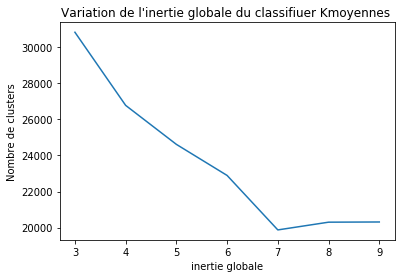

In [143]:
plt.title("Variation de l'inertie globale du classifiuer Kmoyennes ")
plt.xlabel('inertie globale')
plt.ylabel('Nombre de clusters')
plt.plot([3,4,5,6,7,8,9],l)
plt.show()

In [ ]:
f=[]
for k in range(3,20):
    c,aff = kmoyennes(k, data_cat.head(500), 0.6, 10)
    f.append(inertie_globale(data_cat.head(500),aff))